# Virtual species

# Virtual species

In this vignette, we provide a demonstration of how the different **SpeciesDistributionToolkit** functions can be chained together to rapidly create a virtual species, generate its range map, and sample points from it according to the predicted suitability.

In [1]:
using SpeciesDistributionToolkit
using CairoMakie
using Statistics
CairoMakie.activate!(px_per_unit = 6.0)

We start by defining the extent in which we want to create the virtual species. For the purpose of this example, we will use the country of Austria, a polygon of which is available in the GADM database. Note that the `boundingbox` function returns the coordinates *in WGS84*. We have used these commands already in the first case study.

In [2]:
place = SpeciesDistributionToolkit.gadm("PRY")
extent = SpeciesDistributionToolkit.boundingbox(place)

(left = -62.642398834228516, right = -54.25859832763672, bottom = -27.60569953918457, top = -19.29520034790039)

We then download some environmental data. In this example, we use the BioClim variables as distributed by CHELSA. In order to simplify the code, we will only use BIO1 (mean annual temperature) and BIO12 (total annual precipitation). Note that we collect these layers in a vector typed as `SDMLayer{Float32}`, in order to ensure that future operations already recevie floating point values.

In [3]:
provider = RasterData(CHELSA2, BioClim)
L = SDMLayer{Float32}[SDMLayer(provider; layer=l, extent...) for l in ["BIO1", "BIO12"]]

2-element Vector{SDMLayer{Float32}}:
 🗺️  A 998 × 1007 layer (1004986 Float32 cells)
 🗺️  A 998 × 1007 layer (1004986 Float32 cells)

We now mask the layers using the polygons we downloaded initially. Here, this is done in two steps, first the masking of the first layer, and second the masking of all other layers. Currently unreleased versions of the package have a shortcut for this operation.

In [4]:
rescale!.(mask!(L, place))

2-element Vector{SDMLayer{Float32}}:
 🗺️  A 998 × 1007 layer (507665 Float32 cells)
 🗺️  A 998 × 1007 layer (507665 Float32 cells)

In the next steps, we will generate some virtual species. These are defined by an environmental response to each layer, linking the value of the layer at a point to the suitability score. For the sake of expediency, we only use logistic responses, and generate one function for each layer (drawing $\alpha$ from a normal distribution, and $\beta$ uniformly).

In [11]:
logistic(x, α, β) = 1 / (1 + exp((x-β)/α))
logistic(α, β) = (x) -> logistic(x, α, β)

logistic (generic function with 2 methods)

In [27]:
function virtualspecies(L::Vector{<:SDMLayer}; prevalence::Float64 = 0.25)
    prevalence = clamp(prevalence, eps(), 1.0)
    # The center of the response is a random value in the layer
    # The shape is a random Normal
    predictors = [logistic(rand(values(l)), randn()) for l in L]
    # We predict the response by multiplying the values
    prediction = prod([predictors[i].(L[i]) for i in eachindex(L)])
    # We normalize the prediction so it is in 0-1
    rescale!(prediction)
    # We identify the cutoff based on the prevalence
    cutoff = quantile(prediction, 1-prevalence)
    # Then we return the prediction, the cutoff, and the range
    return prediction, cutoff, prediction .>= cutoff
end

virtualspecies (generic function with 1 method)

In the next step, we create a layer of suitability, by applying the logistic function to each environmental variable layer, and taking the product of all suitabilities:

In [36]:
vsp, τ, vrng = virtualspecies(L; prevalence=0.33)

(🗺️  A 998 × 1007 layer (507665 Float64 cells), 0.26496016339540984, 🗺️  A 998 × 1007 layer (507665 Bool cells))

In order to generate the range of the species, we set a target prevalence, and identify the quantile corresponding to this prevalence in the suitability layer.

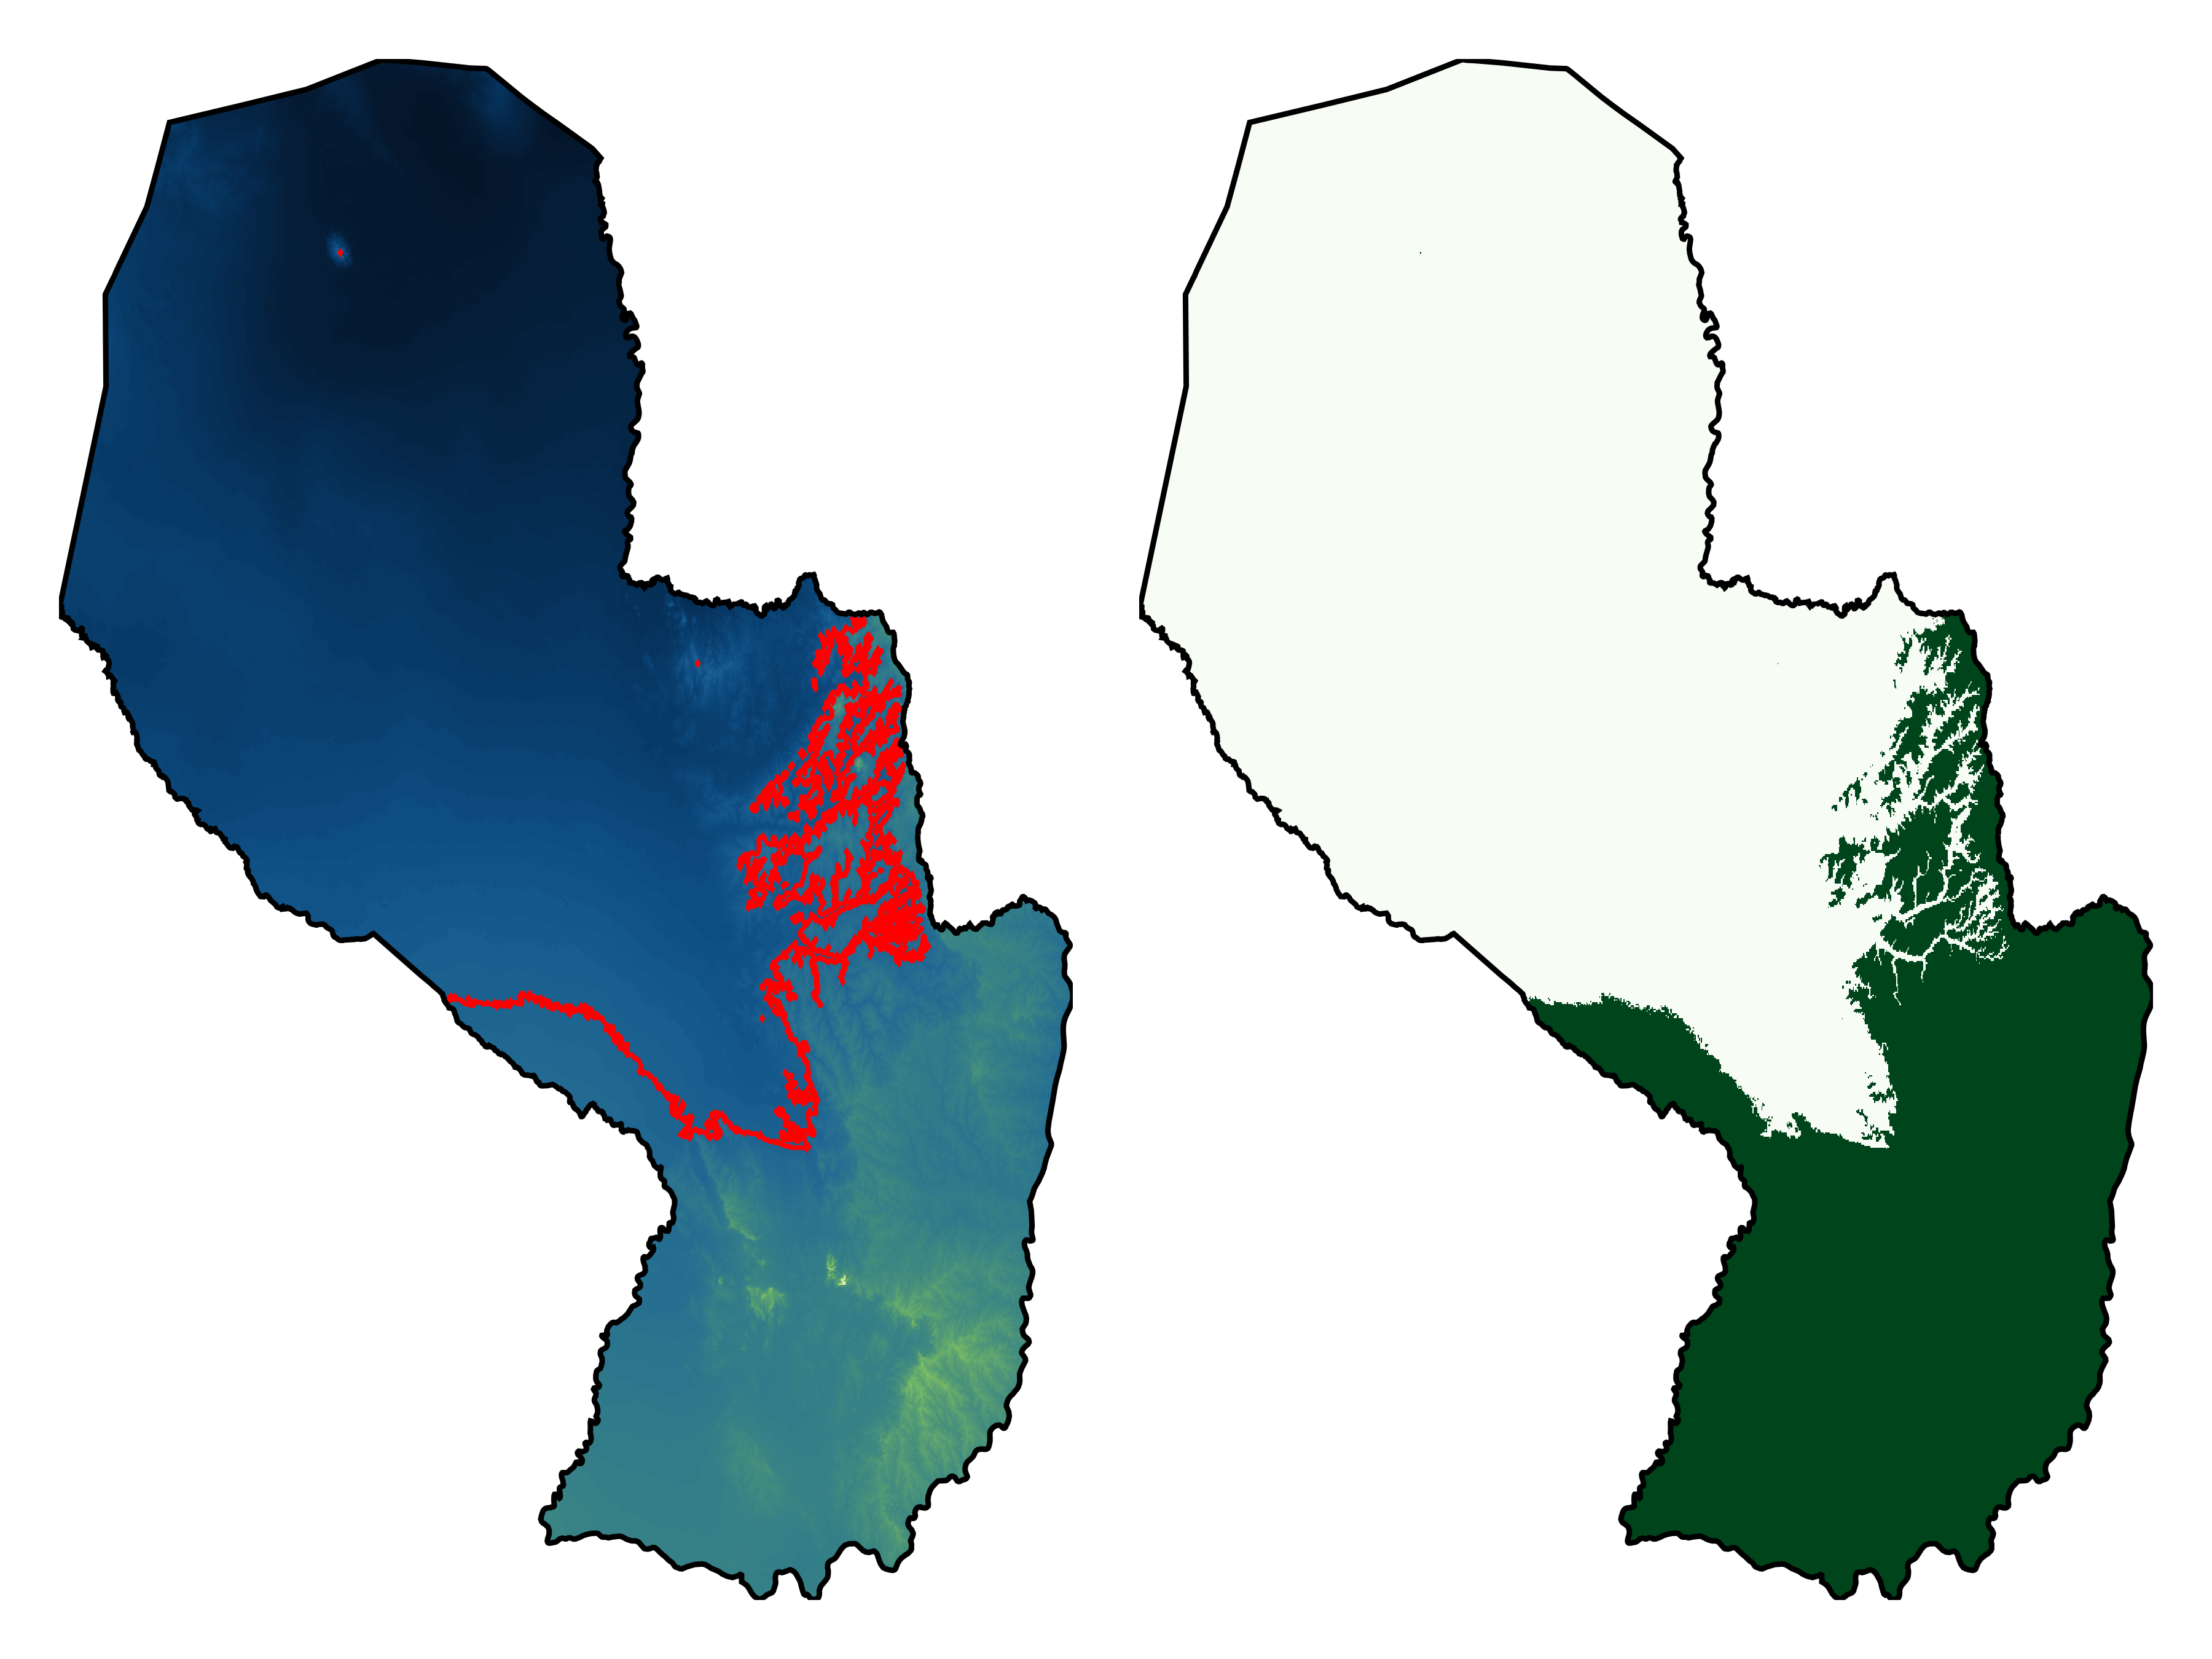

In [ ]:
f = Figure()
ax1 = Axis(f[1,1])
ax2 = Axis(f[1,2])
heatmap!(ax1, vsp, colormap=:navia)
heatmap!(ax2, vrng, colormap=:Greens)
for ax in [ax1, ax2]
    tightlimits!(ax)
    hidedecorations!(ax)
    hidespines!(ax)
    lines!(ax, place[1].geometry, color=:black)
end
f

Random observations for the virtual species are generated by setting the probability of inclusion to 0 for all values above the cutoff, and then sampling proportionally to the suitability for all remaining points. Note that the method is called `backgroundpoints`, as it is normally used for pseudo-absences. The second argument of this method is the number of points to generate.

In [49]:
presencelayer = backgroundpoints(mask(vsp, nodata(vrng, false)), 100)

🗺️  A 998 × 1007 layer with 167530 Bool cells
   Projection: +proj=longlat +datum=WGS84 +no_defs

We can finally plot the result:

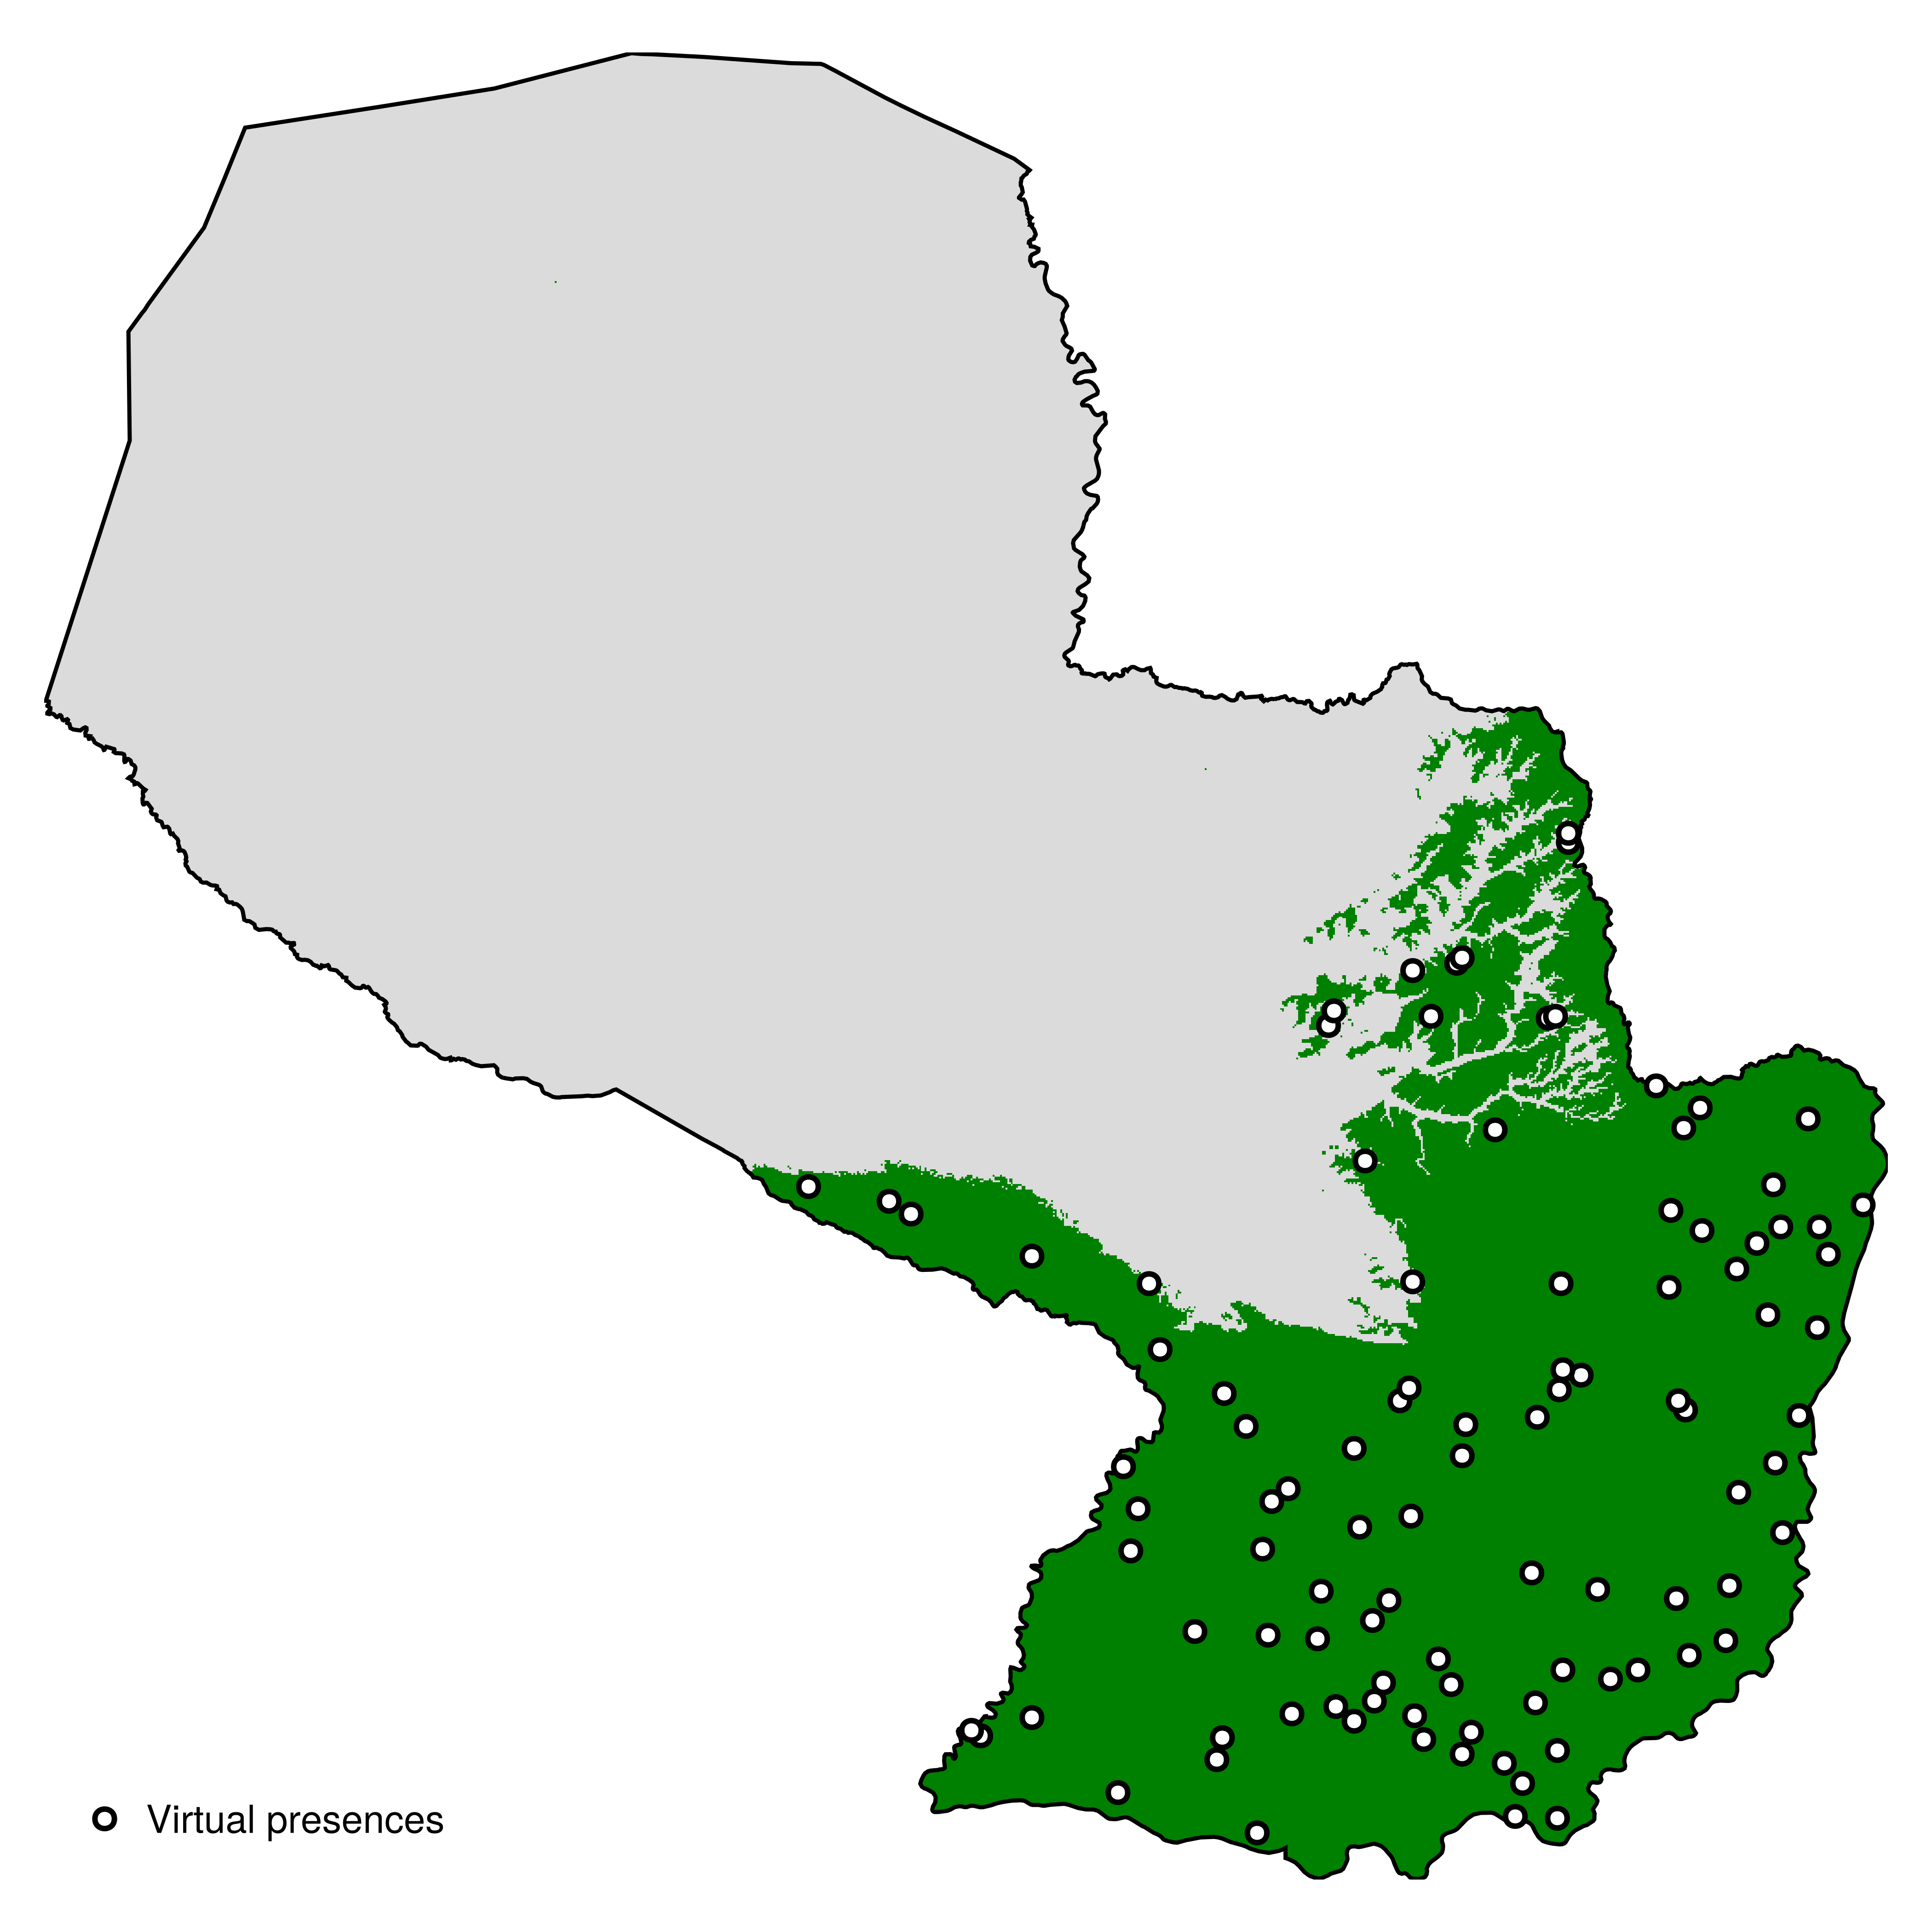

In [ ]:
f = Figure(size=(700, 700))
ax = Axis(f[1,1], aspect=DataAspect())
heatmap!(ax, vrng, colormap=["#cececebb", :green])
lines!(ax, place[1].geometry, color=:black)
scatter!(ax, presencelayer, color=:white, strokecolor=:black, strokewidth=2, markersize=10, label="Virtual presences")
tightlimits!(ax)
hidespines!(ax)
hidedecorations!(ax)
axislegend(ax, position=:lb, framevisible=false)
f

now we do many species

In [ ]:
ranges = [virtualspecies(L; prevalence=rand())[3] for _ in 1:100]

50-element Vector{SDMLayer{Bool}}:
 🗺️  A 998 × 1007 layer (507665 Bool cells)
 🗺️  A 998 × 1007 layer (507665 Bool cells)
 🗺️  A 998 × 1007 layer (507665 Bool cells)
 🗺️  A 998 × 1007 layer (507665 Bool cells)
 🗺️  A 998 × 1007 layer (507665 Bool cells)
 🗺️  A 998 × 1007 layer (507665 Bool cells)
 🗺️  A 998 × 1007 layer (507665 Bool cells)
 🗺️  A 998 × 1007 layer (507665 Bool cells)
 🗺️  A 998 × 1007 layer (507665 Bool cells)
 🗺️  A 998 × 1007 layer (507665 Bool cells)
 ⋮
 🗺️  A 998 × 1007 layer (507665 Bool cells)
 🗺️  A 998 × 1007 layer (507665 Bool cells)
 🗺️  A 998 × 1007 layer (507665 Bool cells)
 🗺️  A 998 × 1007 layer (507665 Bool cells)
 🗺️  A 998 × 1007 layer (507665 Bool cells)
 🗺️  A 998 × 1007 layer (507665 Bool cells)
 🗺️  A 998 × 1007 layer (507665 Bool cells)
 🗺️  A 998 × 1007 layer (507665 Bool cells)
 🗺️  A 998 × 1007 layer (507665 Bool cells)

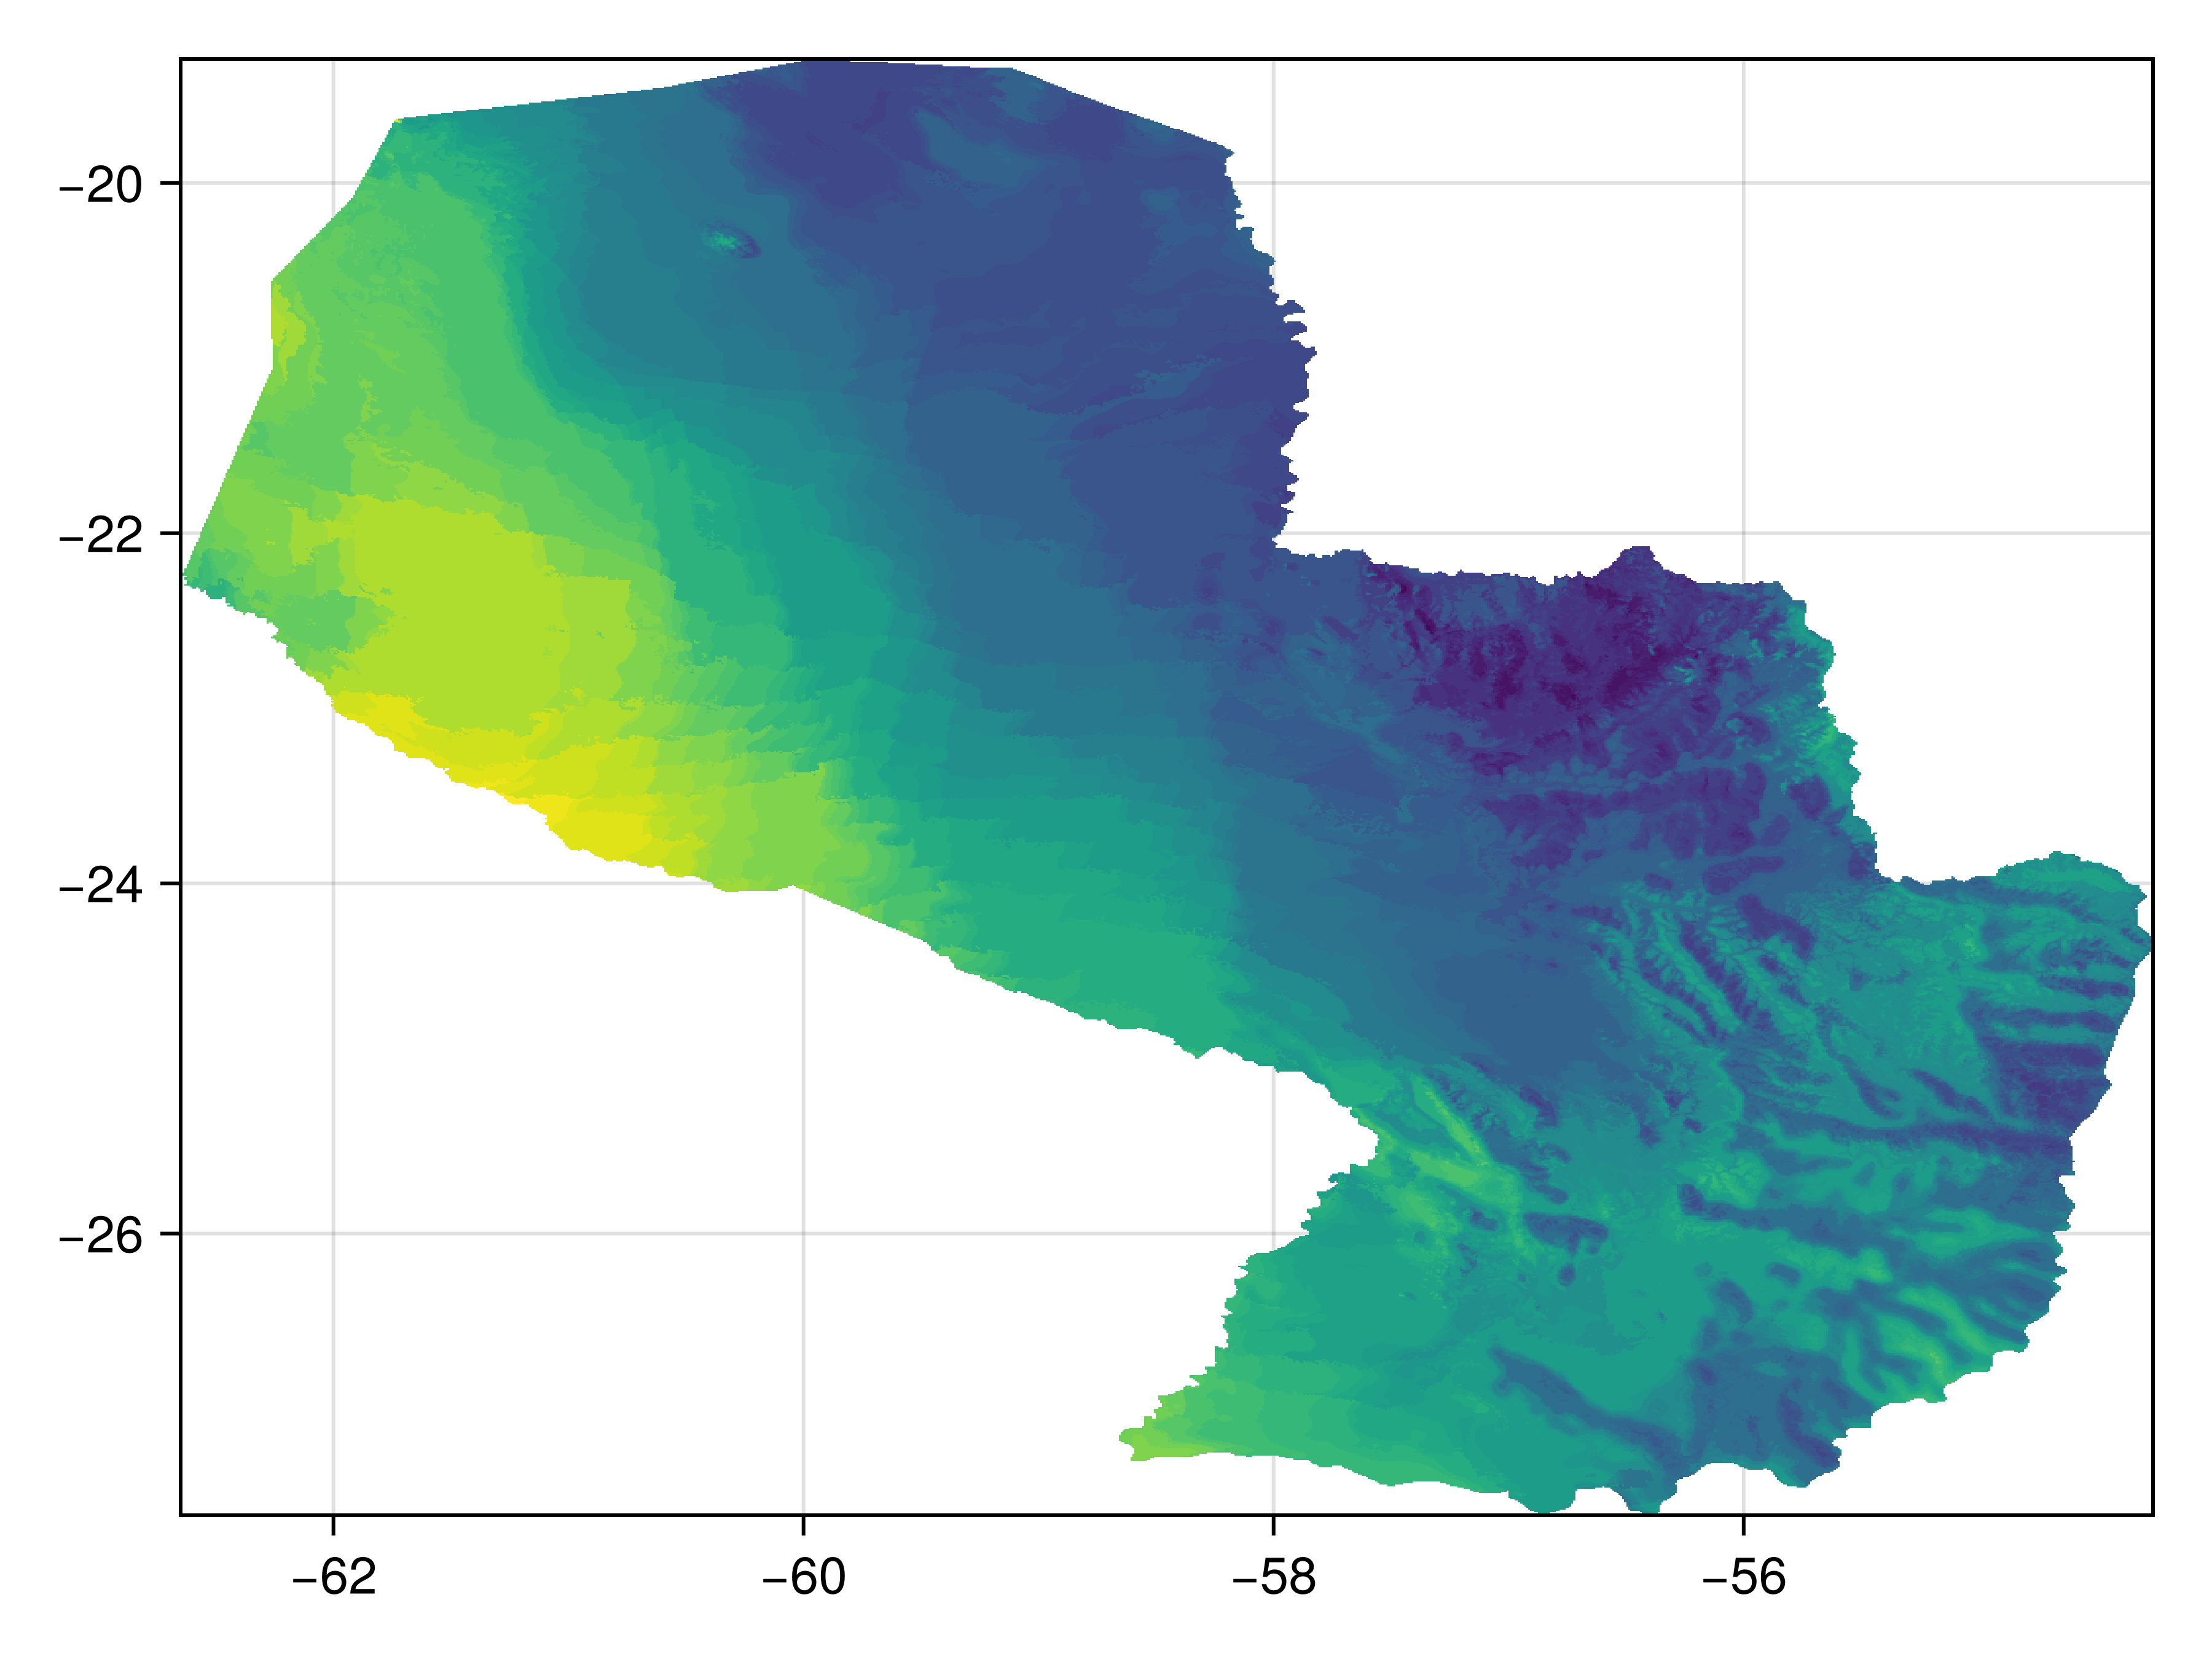

In [84]:
richness = mosaic(sum, ranges)
heatmap(richness)

In [111]:
function LCBD(ranges::Vector{SDMLayer{Bool}}; transformation::Function=identity)
    Y = transformation(hcat(values.(ranges)...))
    S = (Y .- mean(Y; dims=1)).^2.0
    SStotal = sum(S)
    BDtotal = SStotal / (size(Y,1)-1)
    SSj = sum(S; dims=1)
    SCBDj = SSj ./ SStotal
    SSi = sum(S; dims=2)
    LCBDi = SSi ./ SStotal
    # LCBD raster
    betadiv = similar(first(ranges), Float32)
    betadiv.grid[findall(betadiv.indices)] .= vec(LCBDi)
    return betadiv, vec(SCBDj), BDtotal
end

function hellinger(Y::AbstractMatrix{T}) where {T <: Number}
    yi = sum(Y; dims=2)
    return sqrt.(Y ./ yi)
end

hellinger (generic function with 1 method)

In [112]:
βl, βs, βt = LCBD(ranges; transformation=hellinger)

(🗺️  A 998 × 1007 layer (507665 Float32 cells), [0.018868762083847922, 0.01167336021614869, 0.02160151228990129, 0.022725978836660127, 0.007156365165319184, 0.009160841695723877, 0.027887423646073287, 0.02592872766396124, 0.025192320188660158, 0.035504922195652176  …  0.02085026913981015, 0.02239866094588299, 0.009550429195950776, 0.009925661329694857, 0.017569828752015508, 0.01890843140154505, 0.017959094621109294, 0.03547471387075585, 0.020542987649898845, 0.019773886525829485], 0.36114722915391095)

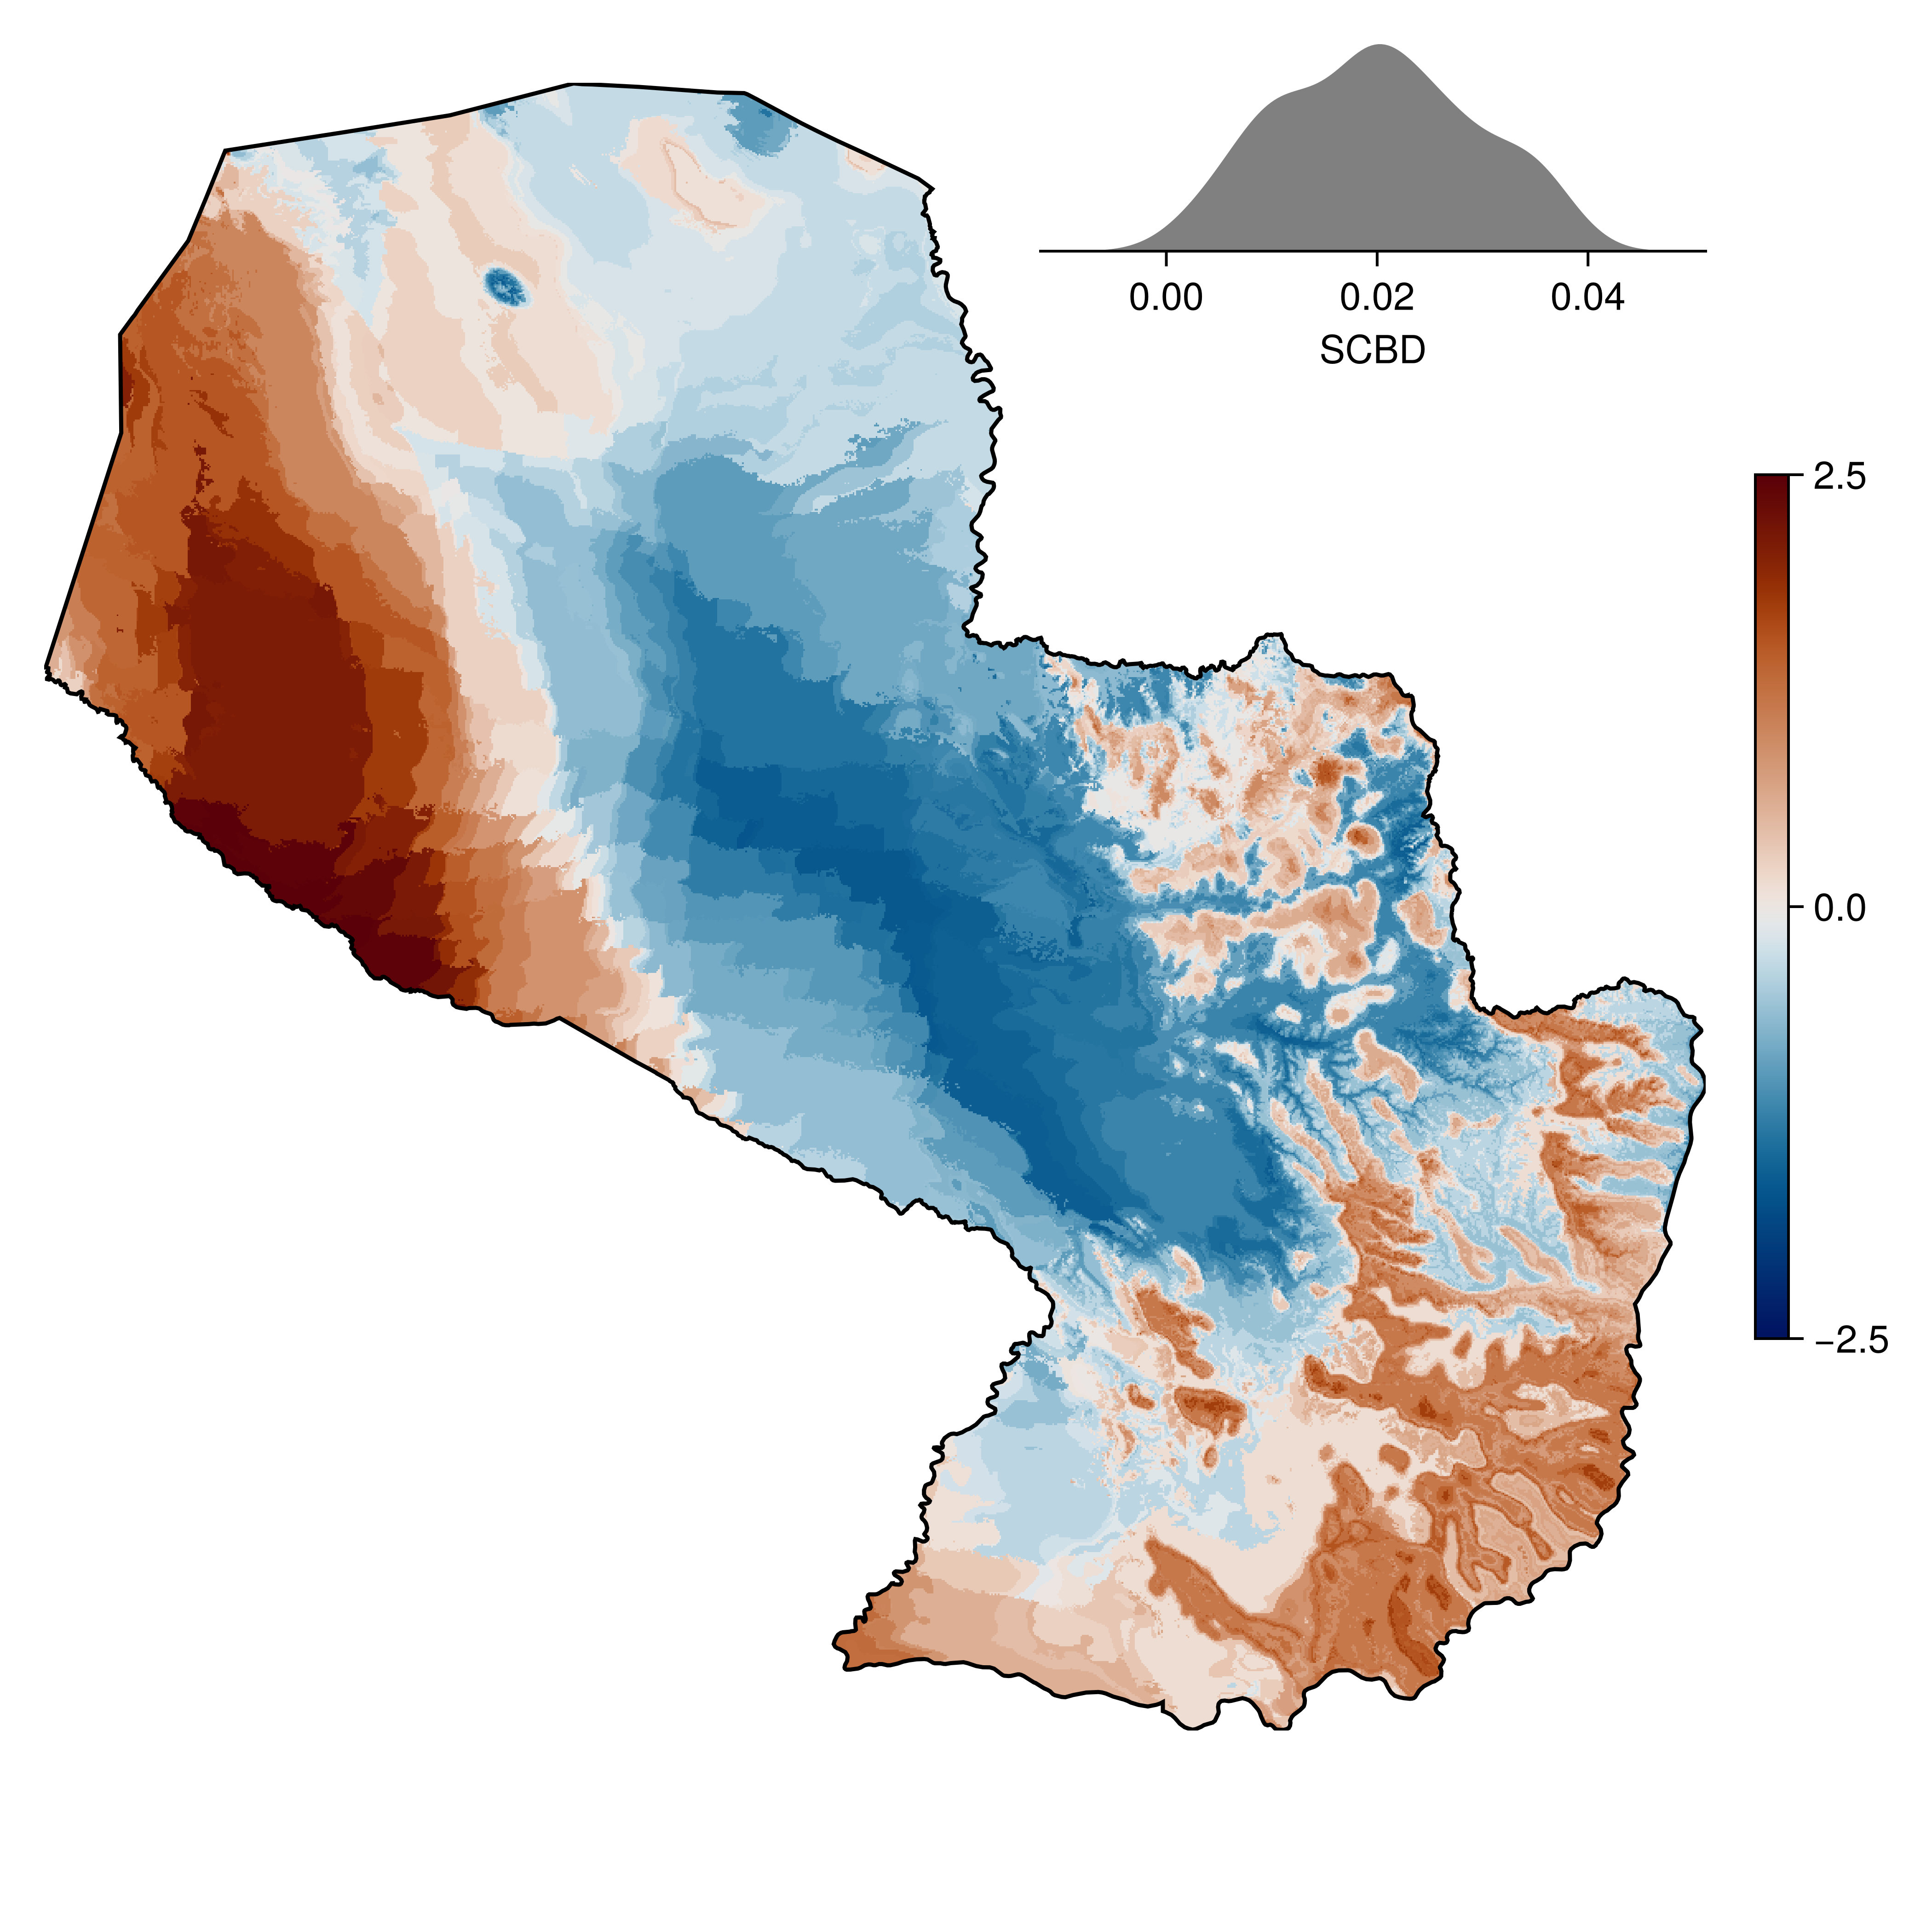

In [129]:
#| label: fig-virtual-species
#| fig-cap: "Virtual distribution for a hypothetical species with logistic response to the environment, as well as a sample of simulated occurrences. The prevalence of the virtual species is equivalent to the results in @fig-sdm-output. The code to produce this ﬁgure is available as Supp. Mat. 4."
f = Figure(size=(700, 700))
ax = Axis(f[1,1], aspect=DataAspect())
hm = heatmap!(ax, (betadiv - mean(betadiv))/std(betadiv), colormap=:vik, colorrange=(-2.5, 2.5))
lines!(ax, place[1].geometry, color=:black)
Colorbar(f[1,2], hm, height=Relative(0.5))
tightlimits!(ax)
hidespines!(ax)
hidedecorations!(ax)
f

ax_inset = Axis(f[1, 1],
    width=Relative(0.4),
    height=Relative(0.12),
    halign=1.0,
    valign=1.0,
    xlabel="SCBD")
    density!(ax_inset, βs, color=:grey)
    hidespines!(ax_inset, :t, :r, :l)
    hideydecorations!(ax_inset)
    hidexdecorations!(ax_inset, ticks=false, ticklabels=false, label=false)
    tightlimits!(ax_inset)
    f